## Mini Project 
By: Ludovica, Inés, Andrew

### Exercise 1 
Read the content of the file and generate the correspondent graph. Choose the right type of graph and decide what you want to do with edges weights.

To understand which type of graph to generate, we looked at the description of the network in the README: 

'Each student was asked to list his 5 best female and his 5 male friends. A node represents a student and an edge between two students shows that the left student chose the right student as a friend. Higher edge weights indicate more interactions and a 0 edge weight shows that there is no common activity at all.'

We decided to use a directed graph (nx.DiGraph) with weights associated with the edges. We decided to maintain the information on the weights to be able to identify which interactions occur more frequently and constitute, therefore, a greater risk factor during the pandemic. 

In [9]:
# the data is loaded using the .read() method, which returns the content of the whole text file
with open('../out.moreno_health_health', 'rb') as infile:
    data = infile.read()
    
type(data), len(data)

(bytes, 142441)

In order to understand how to convert the input data, we used the information on the README again:

'The adjacency matrix of the network is space separated values format, with one edge per line. The meaning of the columns in out.moreno_health are:

        First column: ID of from node 
        Second column: ID of to node
        Third column: edge weight'

In [12]:
# the string is split into the content of each line, which corresponds to one edge
edges = str(data).split('\\n')

#the first 2 and the last line contain additional information that we currently do not need, and will therefore discard
list_edges = [[]]*len(edges[2:-1])
for i in range(len(edges[2:-1])):
    list_edges[i] = edges[2+i].split(' ') #each line of data is transformed into a list containing 3 elements: ID of from node,                                          
                                          #ID of to node, edge weight
    
type(list_edges), len(list_edges)

(list, 12969)

As mentioned above, the created list of lists is converted into a directed graph with weights on its edges.

In [13]:
import networkx as nx

#instantiation of the directed graph
G = nx.DiGraph()

for lst in list_edges:
    G.add_edge(lst[0], lst[1], weight=float(lst[2])) #the first element is used a the from node, the second the to node 
                                                     #and the third as the weight   
len(G)

2539

In [14]:
# saving the network to create a visualization on Gephi
nx.write_gexf(G, "./saved_graph")

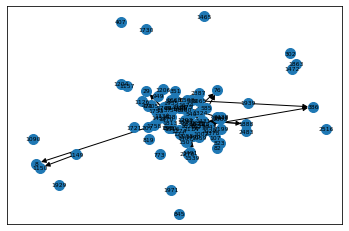

In [35]:
#since the complete visualization is too chaotic, we will visualize a random subgraph of the network
import random
randomlist = []
for i in range(100):
    n = random.randint(1,len(G))
    randomlist.append(str(n))
    
nx.draw_networkx(G.subgraph(randomlist), pos=nx.spring_layout(G), node_size=100, font_size=6) 

### Exercise 2
Given your knowledge of network analysis a school principal has approached you with the following query: "Given the current outbreak of Covid-19 we would like to secure our school. What could we do?". Use your knowledge to think about possible answers to the school principal. 

Write a short report (max 2 pages with pictures) in which you: 

(a) (2 points) Formalise the question you want to answer. The question the school principal asked is very vague. Try to make it formal enough to be studied using network theory. State the question clearly and explain why you think an answer to your question would be relevant.

(b) (6 points) Use one of the measures you have seen in the previous classes to answer the question. After you formalised your idea run some tests (you can use Python and/or Gephi) and write your endings. Make sure to present your data in a nice and understandable way. Gephi rendered graphs are welcome.

#### Question Formalisation

- evaluate whether degree centrality influences the spread of the virus
- model how fast it spreads with and without the most popular people

Measures for how fast it spreads:
- average path length
- how connected the graph is
- clustering coefficient

In [43]:
nx.average_shortest_path_length(G)

5.332392145105309

In [52]:
deg_centrality = nx.degree_centrality(G)

In [55]:
G_ = G.copy()
list_nodes = G.nodes()

for node in list_nodes:
    if deg_centrality[node] > 0.01:
        G_.remove_node(node)
        
len(G_)

2513

In [57]:
nx.average_shortest_path_length(G_)

5.406478350792439

In [46]:
nx.betweenness_centrality(G)

{'1': 0.00044634498750549604,
 '2': 0.0007051103951252551,
 '3': 0.0019257338201296732,
 '4': 0.00031116715515248694,
 '5': 0.001165002891483647,
 '6': 0.00212690168043728,
 '7': 0.00028039174172083114,
 '8': 0.0,
 '9': 0.0020940948810326703,
 '10': 0.004121289955945861,
 '11': 0.00265047831560494,
 '12': 0.0006601116627000361,
 '13': 0.0025506631041203667,
 '14': 0.0010644598800606643,
 '15': 0.004187707328122404,
 '16': 0.0023626050127741683,
 '17': 0.002886987531495373,
 '18': 0.0,
 '19': 0.002317134405587609,
 '20': 0.002671360081145009,
 '21': 0.0026567568875577236,
 '22': 0.00299448444132212,
 '23': 0.0013497681536396454,
 '24': 0.003079283519737941,
 '25': 0.002027177796785992,
 '26': 0.001550592842492917,
 '27': 0.0,
 '28': 0.0,
 '29': 0.0015685108712578224,
 '30': 0.0006385627397111194,
 '31': 0.0,
 '32': 0.0017036491110303306,
 '33': 0.004523113691383056,
 '34': 0.006215116941175662,
 '35': 0.0021062267786270744,
 '36': 0.0005965569740302073,
 '37': 0.004430525930409838,
 '38

In [47]:
nx.eigenvector_centrality(G)

{'1': 0.00011899265091766501,
 '2': 6.67762957251378e-05,
 '3': 6.314480384463204e-05,
 '4': 0.0001959619125733881,
 '5': 0.00023242273731009588,
 '6': 0.0006706577296474664,
 '7': 2.96123073903777e-07,
 '8': 0.0003596692901650569,
 '9': 6.823921007174991e-05,
 '10': 8.838079478471949e-05,
 '11': 0.00023641739381968433,
 '12': 4.3968818722989134e-05,
 '13': 8.979454772542284e-05,
 '14': 5.012670080439142e-05,
 '15': 0.00038861137757586545,
 '16': 0.00037721435907639986,
 '17': 0.0006130438949833549,
 '18': 0.0001467909779057772,
 '19': 0.0002999981467793769,
 '20': 0.0008479058954071706,
 '21': 0.0002125749586150041,
 '22': 0.00023945938550034483,
 '23': 0.00025770980496745013,
 '24': 0.0003192426959970517,
 '25': 7.837969429009386e-05,
 '26': 6.2011476333789084e-06,
 '27': 6.873457687642315e-05,
 '28': 5.943193454456971e-06,
 '29': 4.074605305226489e-06,
 '30': 2.8517912641868534e-06,
 '31': 6.160396814876218e-06,
 '32': 1.6054970141079374e-05,
 '33': 4.1447476611639286e-05,
 '34': 5.

In [50]:
degrees = []
for node in G.nodes():
    degrees.append(G.degree(node))
    
max(degrees)

36

In [51]:
min(degrees)

1